In [20]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load dataset
data = pd.read_csv("ev_charging_patterns.csv")

# Display first few rows to understand the data structure
data.head()

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


In [21]:
# 1. Data Preprocessing and Time Feature Extraction

# 1.1 Handle Missing Values
missing_values = data.isnull().sum()

# Handle Missing Values in critical columns.
data.dropna(subset=['Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)', 'Charging Cost (USD)'], inplace=True)

# 1.2 Extracting detailed time features from Charging Start Time
# Convert Charging Start Time to datetime format
data['Charging Start Time'] = pd.to_datetime(data['Charging Start Time'])
data['Charging End Time'] = pd.to_datetime(data['Charging End Time'])

# Extract hour, 15-minute interval, weekday/weekend, and month from Charging Start Time
data['Hour'] = data['Charging Start Time'].dt.hour
data['Weekday'] = data['Charging Start Time'].dt.weekday
data['Is Weekend'] = data['Weekday'] >= 5
data['Weekday'] = data['Charging Start Time'].dt.day_name()
data['Month'] = data['Charging Start Time'].dt.month

# 1.3 Categorize Time of Day into more specific periods
def categorize_time_of_day(hour):
    if 7 <= hour < 9:
        return "Morning Peak"
    elif 9 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 14:
        return "Midday"
    elif 14 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 19:
        return "Evening Peak"
    elif 19 <= hour < 23:
        return "Evening"
    else:
        return "Late Night"

data['Time of Day'] = data['Hour'].apply(categorize_time_of_day)

# Categorize Time of Day as an ordered categorical variable
time_order = ["Morning Peak", "Morning", "Midday", "Afternoon", "Evening Peak", "Evening", "Late Night"]
data['Time of Day'] = pd.Categorical(data['Time of Day'], categories=time_order, ordered=True)

# Calculate unit cost (USD per kWh) for each charging session
data['Unit Cost (USD per kWh)'] = data['Charging Cost (USD)'] / data['Energy Consumed (kWh)']

# Remove outliers in Unit Cost (USD per kWh)
Q1 = data['Unit Cost (USD per kWh)'].quantile(0.25)
Q3 = data['Unit Cost (USD per kWh)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Unit Cost (USD per kWh)'] >= lower_bound) & (data['Unit Cost (USD per kWh)'] <= upper_bound)]

In [22]:
# 2. Peak Analysis (Time Dimension)

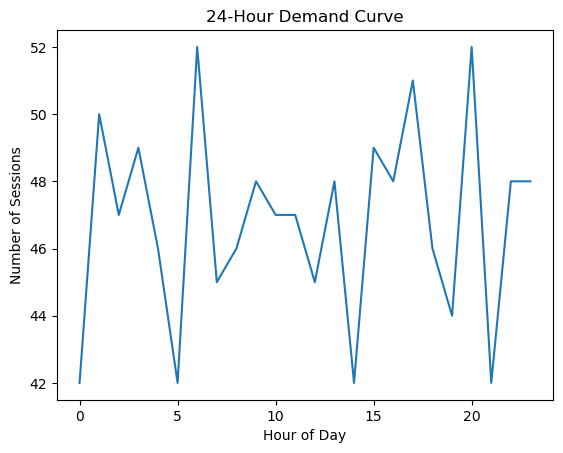

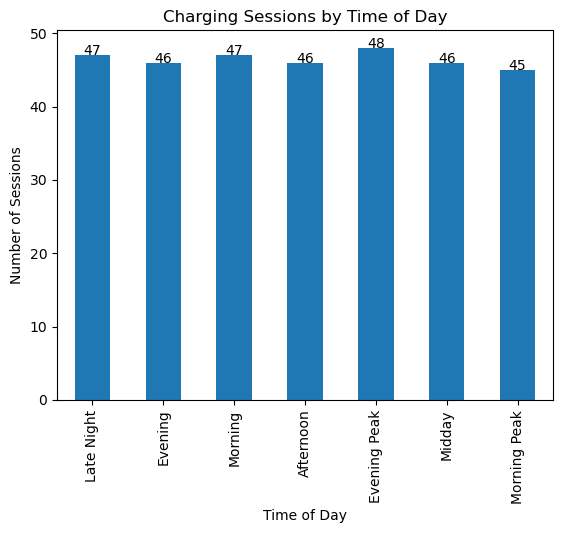

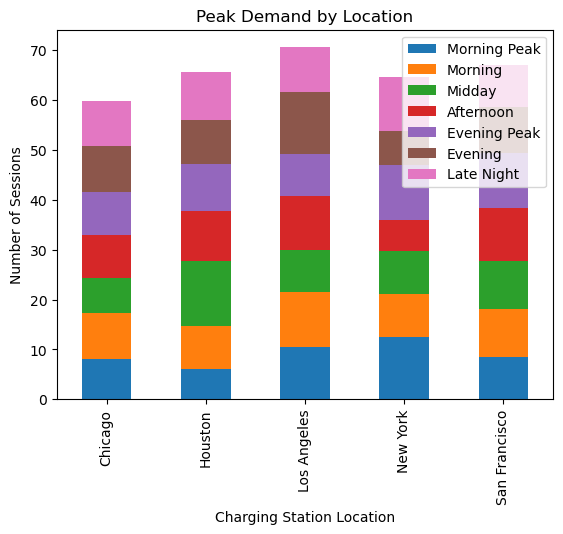

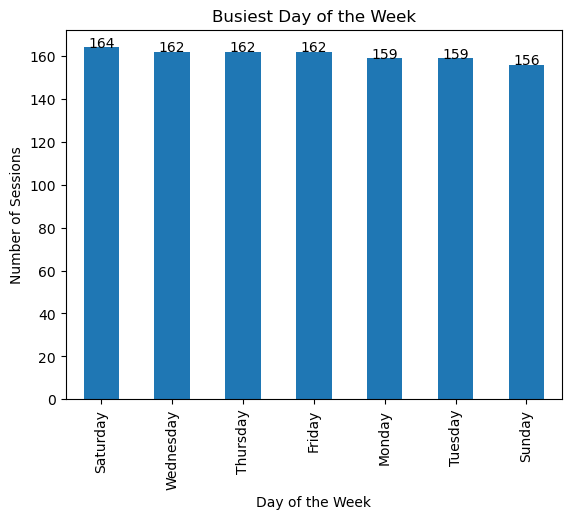

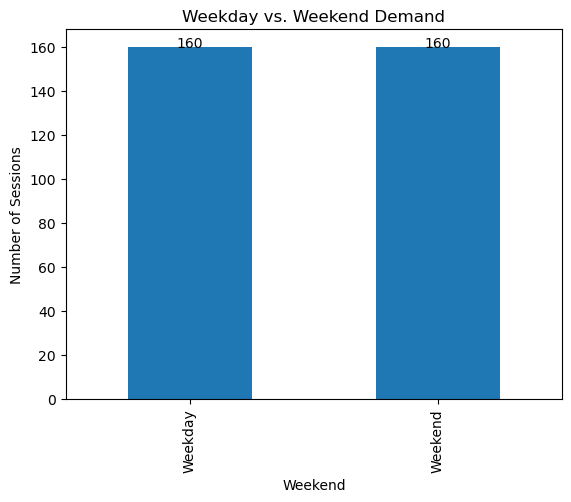

In [31]:
# 2.1 Charging Sessions Count by Time (Univariate Analysis)

# 2.1.1 Count charging sessions by hour (24-hour demand curve)
hourly_sessions = data.groupby('Hour').size()
hourly_sessions.plot(kind='line', title='24-Hour Demand Curve')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.show()

# 2.2.2 Count charging sessions by Time of Day
time_of_day_sessions = data['Time of Day'].value_counts()
# Divide by each time session hours
time_of_day_sessions['Morning Peak'] = int(time_of_day_sessions['Morning Peak'] / 2)
time_of_day_sessions['Evening Peak'] = int(time_of_day_sessions['Evening Peak'] / 2)
time_of_day_sessions['Morning'] = int(time_of_day_sessions['Morning'] / 3)
time_of_day_sessions['Midday'] = int(time_of_day_sessions['Midday'] / 2)
time_of_day_sessions['Afternoon'] = int(time_of_day_sessions['Afternoon'] / 3)
time_of_day_sessions['Evening'] = int(time_of_day_sessions['Evening'] / 4)
time_of_day_sessions['Late Night'] = int(time_of_day_sessions['Late Night'] / 8)

time_of_day_sessions.plot(kind='bar', title='Charging Sessions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Sessions')
for i, v in enumerate(time_of_day_sessions):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

# 2.2.3 Analyzing peak demand differences by charging station location
peak_by_location = data.groupby(['Charging Station Location', 'Time of Day']).size().unstack()
peak_by_location['Morning Peak'] = peak_by_location['Morning Peak'] / 2
peak_by_location['Evening Peak'] = peak_by_location['Evening Peak'] / 2
peak_by_location['Morning'] = peak_by_location['Morning'] / 3
peak_by_location['Midday'] = peak_by_location['Midday'] / 2
peak_by_location['Afternoon'] = peak_by_location['Afternoon'] / 3
peak_by_location['Evening'] = peak_by_location['Evening'] / 4
peak_by_location['Late Night'] = peak_by_location['Late Night'] / 8
peak_by_location.plot(kind='bar', stacked=True, title='Peak Demand by Location')
plt.xlabel('Charging Station Location')
plt.ylabel('Number of Sessions')
plt.legend(loc='upper right')
plt.show()

# 2.2.4 Find the busiest day
busiest_day = data['Weekday'].value_counts()
busiest_day.plot(kind='bar', title='Busiest Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sessions')
for i, v in enumerate(busiest_day):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

# 2.2.5 Compare demand between weekdays and weekends
weekday_sessions = data.groupby('Is Weekend').size()
# Divide by 5 and 2 to get average number of sessions per weekday and weekend
weekday_sessions[0] = int(weekday_sessions[0] / 5)
weekday_sessions[1] = int(weekday_sessions[1] / 2)
weekday_sessions.plot(kind='bar', title='Weekday vs. Weekend Demand')
plt.xlabel('Weekend')
plt.ylabel('Number of Sessions')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
for i, v in enumerate(weekday_sessions):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()


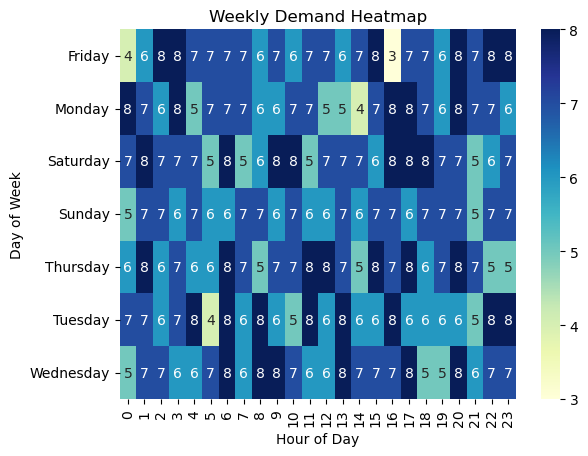

In [24]:
# 2.2 Bivariate Analysis
# Weekly demand heatmap
weekly_demand = data.pivot_table(index='Weekday', columns='Hour', values='User ID', aggfunc='count').fillna(0)
sns.heatmap(weekly_demand, cmap='YlGnBu', annot=True)
plt.title('Weekly Demand Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

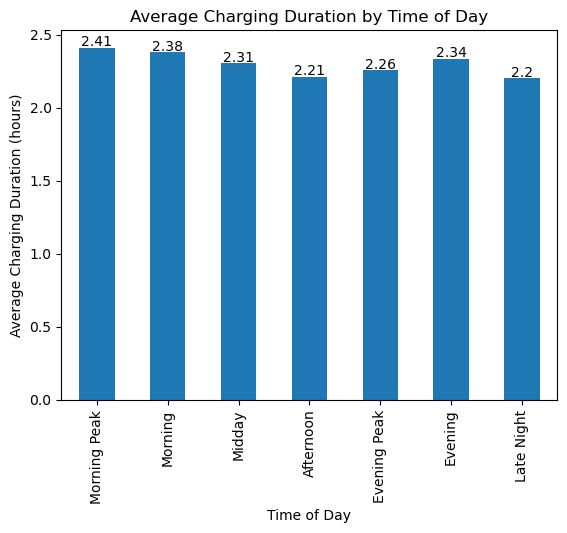

In [25]:
# 2.3 Average charging duration by Time of Day
avg_duration = data.groupby('Time of Day')['Charging Duration (hours)'].mean()
avg_duration.plot(kind='bar', title='Average Charging Duration by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Charging Duration (hours)')
for i, v in enumerate(avg_duration):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()


In [26]:
# 3. Unit Cost Analysis

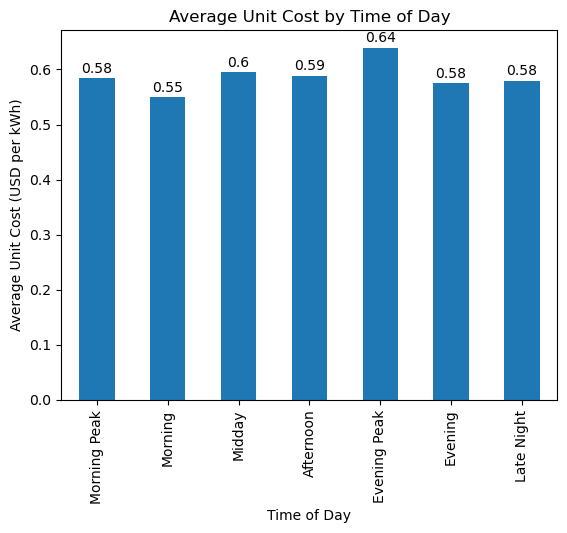

In [27]:
# 3.1 Average Unit Cost per kWh by Time of Day (show exact figures on the plot)
avg_unit_cost = data.groupby('Time of Day')['Unit Cost (USD per kWh)'].mean()
avg_unit_cost.plot(kind='bar', title='Average Unit Cost by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Unit Cost (USD per kWh)')
for i, v in enumerate(avg_unit_cost):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

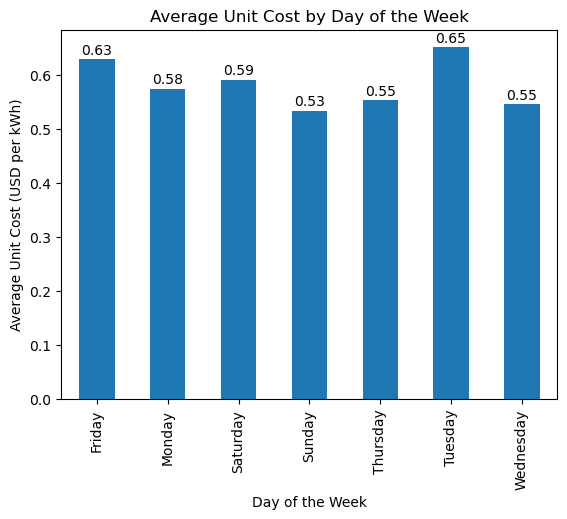

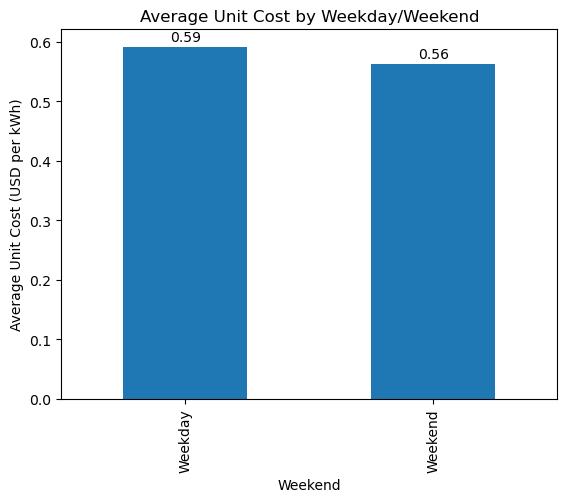

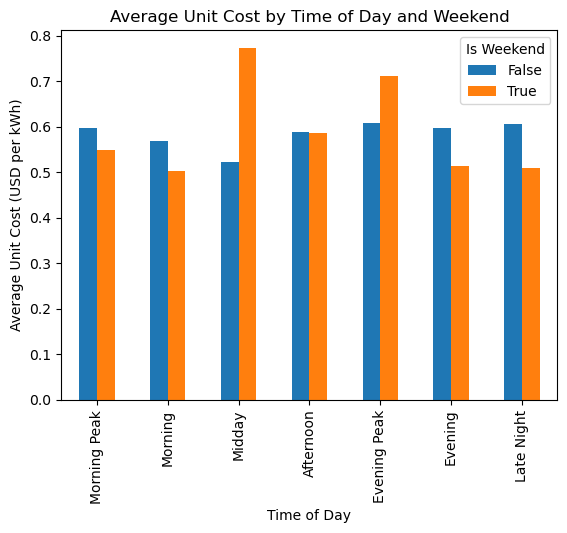

In [28]:
# 3.2 Cost Analysis by Time of Day
# Average Unit Cost by Day of the Week
avg_unit_cost_weekday = data.groupby('Weekday')['Unit Cost (USD per kWh)'].mean()
avg_unit_cost_weekday.plot(kind='bar', title='Average Unit Cost by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Unit Cost (USD per kWh)')
for i, v in enumerate(avg_unit_cost_weekday):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

# Average Unit Cost by Weekday/Weekend
avg_unit_cost_weekend = data.groupby('Is Weekend')['Unit Cost (USD per kWh)'].mean()
avg_unit_cost_weekend.plot(kind='bar', title='Average Unit Cost by Weekday/Weekend')
plt.xlabel('Weekend')
plt.ylabel('Average Unit Cost (USD per kWh)')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
for i, v in enumerate(avg_unit_cost_weekend):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

# Compare average charging cost by Time of Day and between weekdays and weekends
time_costs = data.groupby(['Time of Day', 'Is Weekend'])['Unit Cost (USD per kWh)'].mean().unstack()
time_costs.plot(kind='bar', title='Average Unit Cost by Time of Day and Weekend')
plt.xlabel('Time of Day')
plt.ylabel('Average Unit Cost (USD per kWh)')
plt.show()

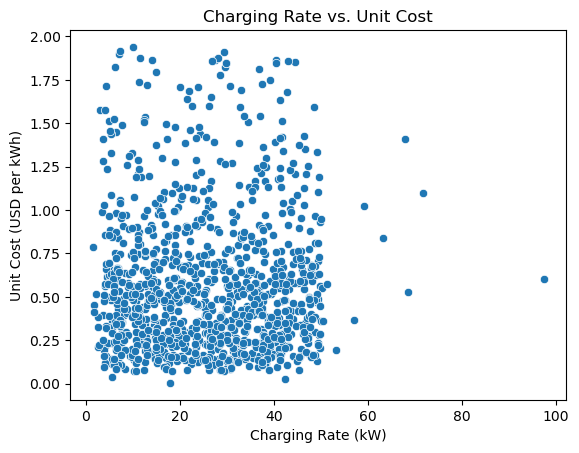

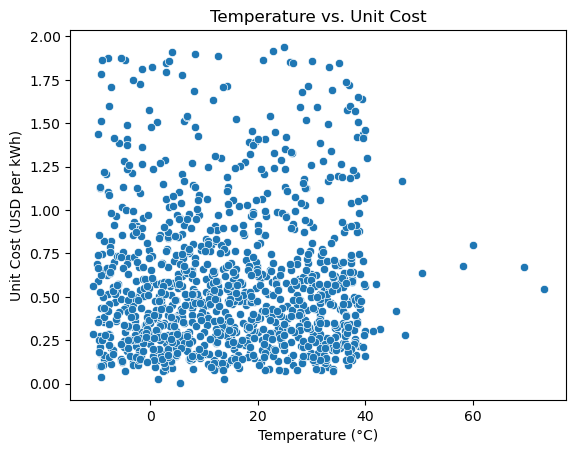

In [29]:
# 3.3 Factors Affecting Charging Costs
# Charging Rate impact on unit cost
sns.scatterplot(data=data, x='Charging Rate (kW)', y='Unit Cost (USD per kWh)')
plt.title('Charging Rate vs. Unit Cost')
plt.xlabel('Charging Rate (kW)')
plt.ylabel('Unit Cost (USD per kWh)')
plt.show()

# Temperature impact on unit cost
sns.scatterplot(data=data, x='Temperature (°C)', y='Unit Cost (USD per kWh)')
plt.title('Temperature vs. Unit Cost')
plt.xlabel('Temperature (°C)')
plt.ylabel('Unit Cost (USD per kWh)')
plt.show()
